# Overview
- [このノートブック](https://www.kaggle.com/nicohrubec/pytorch-multilabel-neural-network/data?select=iterative-stratification-master)をベースにベースラインを作る
- NN(Pytorch)

In [1]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

a010304


# Const

In [2]:
# basic
DEBUG = False
NB = '002'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'

In [3]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 45

dataset:
  name: 
  params:
    
split:
  name: KFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: BCELoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [4]:
import time
import yaml
import random
import numpy as np
import pandas as pd
from fastprogress import progress_bar
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [5]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [6]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Preparation

set

In [7]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])

In [8]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [9]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
test_features = pd.read_csv(PATH_TEST)

ss = pd.read_csv(PATH_SUB)

In [10]:
if DEBUG:
    print(':: debug mode ::')
    train_features = train_features.iloc[::100, :]
    train_targets = train_targets.iloc[::100, :]
    test_features = train_features.iloc[::100, :]

<br>

preprocess

In [11]:
train = preprocess(train_features)
test = preprocess(test_features).values

del train_targets['sig_id']

targets = [col for col in train_targets.columns]
train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [12]:
print(f'train shape:         {train.shape}')
print(f'test shape:          {test.shape}')
print(f'train_targets shape: {train_targets.shape}')

train shape:         (21948, 875)
test shape:          (3982, 875)
train_targets shape: (21948, 206)


# Create model

In [13]:
n_splits = settings['split']['params']['n_splits']
n_epochs = settings['globals']['num_epochs']
splitter = KFold(**settings['split']['params'])
device = settings['globals']['device']
criterion = criterion_ = nn.__getattribute__(
    settings['loss']['name'])(**settings['loss']['params'])

In [14]:
class MoaModel(nn.Module):
    def __init__(self, num_columns):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_columns)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_columns, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.sigmoid(self.dense3(x))
        
        return x

In [15]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

In [16]:
def mean_log_loss(y_true, y_pred):
    metrics = []
    for i, target in enumerate(targets):
        metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
    return np.mean(metrics)

----------------------------------------------------------------------------------------------------
:: start fold 1/5 at Tue Oct 13 11:56:59 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.39338   val_loss: 0.06377   mean_log_loss: 0.06171
Epoch 02/45   loss: 0.03525   val_loss: 0.02362   mean_log_loss: 0.02326
Epoch 03/45   loss: 0.02302   val_loss: 0.02090   mean_log_loss: 0.02046
Epoch 04/45   loss: 0.02125   val_loss: 0.01992   mean_log_loss: 0.01949
Epoch 05/45   loss: 0.02046   val_loss: 0.01943   mean_log_loss: 0.01899
Epoch 06/45   loss: 0.01998   val_loss: 0.01916   mean_log_loss: 0.01875
Epoch 07/45   loss: 0.01962   val_loss: 0.01890   mean_log_loss: 0.01850
Epoch 08/45   loss: 0.01946   val_loss: 0.01882   mean_log_loss: 0.01843
Epoch 09/45   loss: 0.01926   val_loss: 0.01872   mean_log_loss: 0.01832
Epoch 10/45   loss: 0.01914   val_loss: 0.01870   mean_log_loss: 0.01832
Epoch 11/45   loss:

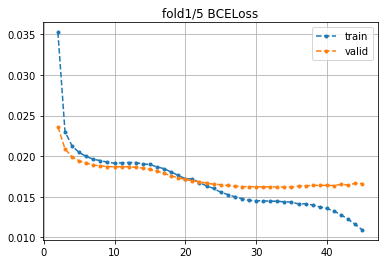



----------------------------------------------------------------------------------------------------
:: start fold 2/5 at Tue Oct 13 11:57:56 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.40799   val_loss: 0.06912   mean_log_loss: 0.06698
Epoch 02/45   loss: 0.03579   val_loss: 0.02304   mean_log_loss: 0.02347
Epoch 03/45   loss: 0.02277   val_loss: 0.02086   mean_log_loss: 0.02125
Epoch 04/45   loss: 0.02132   val_loss: 0.02005   mean_log_loss: 0.02051
Epoch 05/45   loss: 0.02067   val_loss: 0.01965   mean_log_loss: 0.02001
Epoch 06/45   loss: 0.02010   val_loss: 0.01924   mean_log_loss: 0.01953
Epoch 07/45   loss: 0.01973   val_loss: 0.01898   mean_log_loss: 0.01924
Epoch 08/45   loss: 0.01947   val_loss: 0.01886   mean_log_loss: 0.01908
Epoch 09/45   loss: 0.01936   val_loss: 0.01877   mean_log_loss: 0.01896
Epoch 10/45   loss: 0.01927   val_loss: 0.01876   mean_log_loss: 0.01894
Epoch 11/45   los

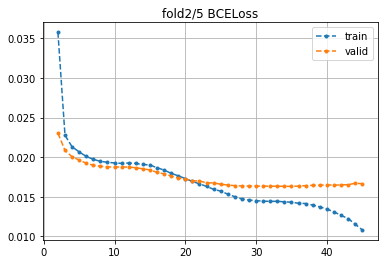



----------------------------------------------------------------------------------------------------
:: start fold 3/5 at Tue Oct 13 11:58:52 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.42395   val_loss: 0.06602   mean_log_loss: 0.06482
Epoch 02/45   loss: 0.03764   val_loss: 0.02300   mean_log_loss: 0.02241
Epoch 03/45   loss: 0.02292   val_loss: 0.02091   mean_log_loss: 0.02033
Epoch 04/45   loss: 0.02135   val_loss: 0.02014   mean_log_loss: 0.01957
Epoch 05/45   loss: 0.02058   val_loss: 0.01955   mean_log_loss: 0.01901
Epoch 06/45   loss: 0.02003   val_loss: 0.01919   mean_log_loss: 0.01869
Epoch 07/45   loss: 0.01966   val_loss: 0.01899   mean_log_loss: 0.01851
Epoch 08/45   loss: 0.01940   val_loss: 0.01886   mean_log_loss: 0.01837
Epoch 09/45   loss: 0.01933   val_loss: 0.01879   mean_log_loss: 0.01833
Epoch 10/45   loss: 0.01922   val_loss: 0.01877   mean_log_loss: 0.01831
Epoch 11/45   los

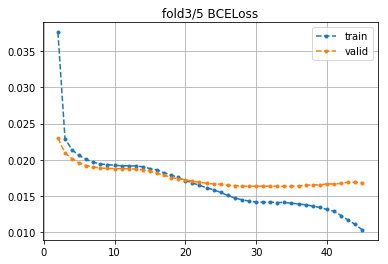



----------------------------------------------------------------------------------------------------
:: start fold 4/5 at Tue Oct 13 11:59:47 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.40953   val_loss: 0.06622   mean_log_loss: 0.06450
Epoch 02/45   loss: 0.03615   val_loss: 0.02310   mean_log_loss: 0.02180
Epoch 03/45   loss: 0.02278   val_loss: 0.02131   mean_log_loss: 0.02012
Epoch 04/45   loss: 0.02128   val_loss: 0.02045   mean_log_loss: 0.01927
Epoch 05/45   loss: 0.02044   val_loss: 0.01990   mean_log_loss: 0.01877
Epoch 06/45   loss: 0.01988   val_loss: 0.01959   mean_log_loss: 0.01840
Epoch 07/45   loss: 0.01949   val_loss: 0.01936   mean_log_loss: 0.01826
Epoch 08/45   loss: 0.01922   val_loss: 0.01923   mean_log_loss: 0.01814
Epoch 09/45   loss: 0.01909   val_loss: 0.01917   mean_log_loss: 0.01805
Epoch 10/45   loss: 0.01900   val_loss: 0.01914   mean_log_loss: 0.01802
Epoch 11/45   los

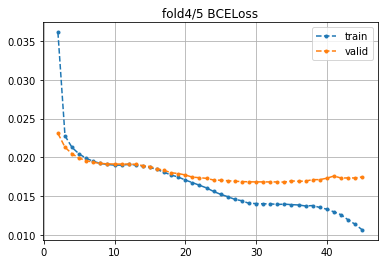



----------------------------------------------------------------------------------------------------
:: start fold 5/5 at Tue Oct 13 12:00:44 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.39141   val_loss: 0.06084   mean_log_loss: 0.06035
Epoch 02/45   loss: 0.03505   val_loss: 0.02324   mean_log_loss: 0.02329
Epoch 03/45   loss: 0.02274   val_loss: 0.02095   mean_log_loss: 0.02100
Epoch 04/45   loss: 0.02130   val_loss: 0.02018   mean_log_loss: 0.02017
Epoch 05/45   loss: 0.02057   val_loss: 0.01967   mean_log_loss: 0.01975
Epoch 06/45   loss: 0.02011   val_loss: 0.01949   mean_log_loss: 0.01960
Epoch 07/45   loss: 0.01982   val_loss: 0.01922   mean_log_loss: 0.01930
Epoch 08/45   loss: 0.01948   val_loss: 0.01901   mean_log_loss: 0.01911
Epoch 09/45   loss: 0.01934   val_loss: 0.01895   mean_log_loss: 0.01907
Epoch 10/45   loss: 0.01936   val_loss: 0.01894   mean_log_loss: 0.01906
Epoch 11/45   los

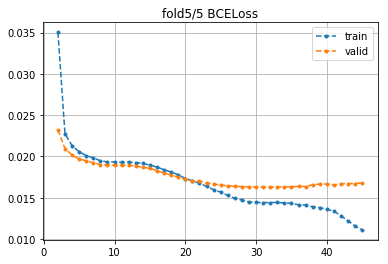



----------------------------------------------------------------------------------------------------
mean_log_loss(all fold): 0.01608 +- 0.00039
----------------------------------------------------------------------------------------------------
CPU times: user 1min 21s, sys: 2min 57s, total: 4min 19s
Wall time: 4min 40s


In [17]:
%%time
mean_log_loss_list = []
best_mean_log_loss = np.inf
for n, (idx_trn, idx_val) in enumerate(splitter.split(train_targets, train_targets)):
    print('-'*100)
    print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
    print('-'*100)
    X_trn, X_val = train[idx_trn], train[idx_val]
    y_trn, y_val = train_targets[idx_trn], train_targets[idx_val]

    train_set = MoaDataset(X_trn, y_trn, mode='train')
    val_set = MoaDataset(X_val, y_val, mode='train')

    dataloaders = {
        'train': DataLoader(train_set, **settings['loader']['train']),
        'val': DataLoader(val_set, **settings['loader']['val']),
    }

    model = MoaModel(train.shape[1]).to(device)
    checkpoint_path = f'Fold{n+1}of{n_splits}.pt'
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    scheduler = optim.lr_scheduler.__getattribute__(settings['scheduler']['name'])(
        optimizer, **settings['scheduler']['params'])
    best_loss = {'train': np.inf, 'val': np.inf}

    val_losses = []
    trn_losses = []
    for epoch in range(n_epochs):
        epoch_loss = {'train': 0.0, 'val': 0.0}

        for phase in ['train', 'val']:
            model.train() if phase=='train' else model.eval()

            running_loss = 0.0
            target_oof = []
            pred_oof = []
            for i, (x, y) in enumerate(dataloaders[phase]):
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    preds = model(x)
                    loss = criterion(preds, y)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() / len(dataloaders[phase])

            epoch_loss[phase] = running_loss
            if phase=='train':
                trn_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                target_oof.append(y)
                pred_oof.append(preds)
        scheduler.step()

        # score
        target_oof = torch.cat(target_oof, dim=0).cpu().numpy()
        pred_oof = torch.cat(pred_oof, dim=0).cpu().numpy()
        _mean_log_loss = mean_log_loss(target_oof, pred_oof)
        
        if epoch_loss['val'] < best_loss['val']:
            best_loss = epoch_loss
            if not DEBUG:
                torch.save(model.state_dict(), checkpoint_path)
                best_mean_log_loss = _mean_log_loss
        print(f"Epoch {str(epoch+1).zfill(2)}/{n_epochs }   loss: {epoch_loss['train']:5.5f}   val_loss: {epoch_loss['val']:5.5f}   mean_log_loss: {_mean_log_loss:5.5f}")

    # result
    print(f'best mean_log_loss: {best_mean_log_loss:5.5f}')
    mean_log_loss_list.append(best_mean_log_loss)
    # plot
    x = np.arange(1, len(trn_losses)+1)
    plt.figure()
    plt.plot(x[1:], trn_losses[1:], '--.', label='train')
    plt.plot(x[1:], val_losses[1:], '--.', label='valid')
    plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
    plt.grid()
    plt.legend()
    plt.show()
    print('\n')
# result
mean_mean_log_loss = np.mean(mean_log_loss_list)
std_mean_log_loss = np.std(mean_log_loss_list)
print('-'*100)
print(f"mean_log_loss(all fold): {mean_mean_log_loss:5.5f} +- {std_mean_log_loss:5.5f}")
print('-'*100)